## Image captioning using reinforcement learning
### Policy to actor method on deep convolution and recurrent networks
#### Project Seminar for artifical intelligence WS2021-22
##### Authors : Viswambhar Yasa, Venkata Mukund 


In [1]:
!git clone https://github.com/viswambhar-yasa/image_captioning

Cloning into 'image_captioning'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 55 (delta 25), reused 18 (delta 6), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [2]:
cd /content/image_captioning

/content/image_captioning


In [3]:
from data_extraction import downloading_extraction

In [4]:
images_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
downloading_extraction(images_link)
text_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
downloading_extraction(text_link)
glove_link='https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
downloading_extraction(glove_link)

In [5]:
import tensorflow as tf

In [6]:
captions_path=r"/content/image_captioning/Flickr8k.token.txt"

In [7]:
text = open(captions_path, 'r', encoding='utf-8').read()
description_map=dict()
for lines in text.split('\n'):
  line_split = lines.split('\t')
  if line_split == ['']:
      continue
  image_id = line_split[0][:-2]
  image_des = line_split[1]
  #if image_id in img_dic:
  if image_id not in description_map:
    description_map[image_id] = list()
  description_map[image_id].append(image_des)
caption_list = []
for img_id, des_list in description_map.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        caption = ''.join(caption)
        caption = caption.split(' ')
        caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
        caption = ' '.join(caption)
        des_list[i] = 'startseq ' + caption + ' endseq'
        caption_list.append('startseq ' + caption + ' endseq')
max_length = max(len(des.split()) for des in caption_list)
print('max_length of captions', max_length)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8350,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

max_length of captions 33


In [8]:
import os

In [9]:
word_index=tokenizer.word_index

In [10]:
word_index={value:key for key, value in word_index.items()}

In [11]:
len(word_index)

8360

In [12]:
from model_networks import Caption_model_gen

In [33]:
from data_generator import captions_generation_policy,load_preprocess_img

In [14]:
description_map['2258277193_586949ec62.jpg.1']

['startseq people waiting for the subway endseq',
 'startseq some people looking out windows in large building endseq',
 'startseq three people are waiting on train platform endseq',
 'startseq three people standing at station endseq',
 'startseq two woman and one man standing near train tracks endseq']

In [15]:
description_map['2258277193_586949ec62.jpg'] = description_map['2258277193_586949ec62.jpg.1']
del description_map['2258277193_586949ec62.jpg.1']

In [16]:
del description_map['2258277193_586949ec62.jpg']

In [17]:
description_map1=dict()

In [18]:
files=os.listdir("/content/image_captioning/Flicker8k_Dataset")

In [19]:
for key,value in description_map.items():
  if key in files:
    description_map1[key]=value

In [20]:
print(len(tokenizer.word_counts))

8359


In [21]:
token_cap_dic = dict()
print('Vocab size',len(tokenizer.word_counts))
for img_id, des_list in description_map1.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        cap_token = tokenizer.texts_to_sequences([str(caption)])
        if img_id not in token_cap_dic:
            token_cap_dic[img_id] = list()
        token_cap_dic[img_id].append(cap_token)

Vocab size 8359


In [22]:
description_map['1001773457_577c3a7d70.jpg'],token_cap_dic['1001773457_577c3a7d70.jpg']

(['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 [[[2, 15, 9, 8, 848, 9, 17, 341, 3]],
  [[2, 15, 9, 8, 9, 34, 10, 137, 82, 6, 5, 154, 3]],
  [[2, 15, 9, 8, 14, 9, 10, 27, 992, 17, 635, 22, 137, 82, 4, 5, 72, 3]],
  [[2, 13, 31, 12, 735, 2614, 88, 22, 137, 82, 6, 5, 154, 3]],
  [[2, 13, 31, 6, 717, 793, 317, 137, 82, 3]]])

In [23]:
cd /content/image_captioning

/content/image_captioning


In [25]:
import matplotlib.pyplot as plt

In [27]:
import pickle

print('TensorFlow Version', tf.__version__)
vocab_size = 8360
max_length = 25

captions_text_path = r'/content/image_captioning/Flickr8k.token.txt'
captions_extraction = data_processing(captions_text_path)
trn_images_id_text = r'/content/image_captioning/Flickr_8k.trainImages.txt'
train_cleaned_seq, train_cleaned_dic = captions_extraction.cleaning_sequencing_captions(trn_images_id_text)
val_images_id_text = r'/content/image_captioning/Flickr_8k.devImages.txt'
val_cleaned_seq, val_cleaned_dic = captions_extraction.cleaning_sequencing_captions(val_images_id_text)
test_images_id_text = r'/content/image_captioning/Flickr_8k.testImages.txt'
test_cleaned_seq, test_cleaned_dic = captions_extraction.cleaning_sequencing_captions(test_images_id_text)
tokenizer=captions_extraction.tokenization(train_cleaned_seq, vocab_size)
print("No of captions: Training-" + str(len(train_cleaned_seq) / 5) + " Validation-" + str(
    len(val_cleaned_seq) / 5) + " test-" + str(len(test_cleaned_seq) / 5))

train_cap_tok = captions_extraction.sentence_tokenizing(train_cleaned_dic)
val_cap_tok = captions_extraction.sentence_tokenizing(val_cleaned_dic)
test_cap_tok = captions_extraction.sentence_tokenizing(test_cleaned_dic)

image_pth_rt = r"/content/image_captioning/Flicker8k_Dataset/" #+ r"\\"
trn_dataset = captions_generation_policy(train_cap_tok, vocab_size, image_pth_rt, 25,32,1)
val_dataset = captions_generation_policy(val_cap_tok, vocab_size, image_pth_rt, 25,32,1)
tokenizer

TensorFlow Version 2.8.0
max_length of captions 33
max_length of captions 31
max_length of captions 30
No of captions: Training-6000.0 Validation-1000.0 test-1000.0
Vocab size 8360
Vocab size 8360
Vocab size 8360


In [29]:
trn_dataset_whole = captions_generation_policy(token_cap_dic, 8360, image_pth_rt, 25,32,1)

In [30]:
len(train_cleaned_seq)

30000

In [31]:
inputs, outputs = next(iter(trn_dataset_whole))
print(inputs[0].shape, inputs[1].shape, outputs.shape)

(349, 256, 256, 3) (349, 25) (349, 8360)


In [32]:
actor_model = Caption_model_gen(NET='policy',Embedding_layer=None, vocab_size=8360, Embed_Size=512, max_length=25,display=True)

actor_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=['accuracy'])

Building CNN model
83697664/83683744 [==============================] - 1s 0us/step
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {add shape}: (None, 512)
output {shape} (None, 8360)
Policy Net built successfully 



In [ ]:
actor_model.summary()

Model: "Policy_Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                        

In [ ]:
#actor_model.load_weights('/content/drive/MyDrive/Kaggle/policy_net_weights_xception1.h5')

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = '/content'
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=10)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy',
    mode='auto')

callback = [model_checkpoint_callback]

history = actor_model.fit(trn_dataset_whole,epochs=200,steps_per_epoch=30, shuffle=False, validation_data=val_dataset,validation_steps=1)
#history = actor_model.fit(trn_dataset, steps_per_epoch=10, epochs=100, shuffle=False,callbacks=lr_callback)
model_parameters = history.history

Epoch 1/200
30/30 [==============================] - 120s 3s/step - loss: 6.2997 - accuracy: 0.1102 - val_loss: 6.0306 - val_accuracy: 0.0823
Epoch 2/200
30/30 [==============================] - 59s 2s/step - loss: 5.4472 - accuracy: 0.1557 - val_loss: 6.1711 - val_accuracy: 0.0516
Epoch 3/200
30/30 [==============================] - 50s 2s/step - loss: 5.2195 - accuracy: 0.1823 - val_loss: 6.5952 - val_accuracy: 0.0672
Epoch 4/200
30/30 [==============================] - 47s 2s/step - loss: 5.1385 - accuracy: 0.1849 - val_loss: 6.5022 - val_accuracy: 0.0820
Epoch 5/200
30/30 [==============================] - 53s 2s/step - loss: 5.0512 - accuracy: 0.1915 - val_loss: 6.2339 - val_accuracy: 0.1283
Epoch 6/200
30/30 [==============================] - 42s 1s/step - loss: 4.9066 - accuracy: 0.2020 - val_loss: 6.7770 - val_accuracy: 0.1154
Epoch 7/200
30/30 [==============================] - 44s 1s/step - loss: 4.8704 - accuracy: 0.1972 - val_loss: 6.1210 - val_accuracy: 0.1288
Epoch 8/200


In [ ]:
f = open("/content/history_policy_model_xception_3_lstm.pkl", "wb")
pickle.dump(model_parameters, f)
f.close()   

In [ ]:
#actor_model.save_weights('/content/policy_net_weights_xception_best_final_bi_3.h5')

In [ ]:
actor_model.save_weights('/content/policy_net_weights_xception_lstm_3.h5')

In [ ]:
print(history.history)
f = open("/content/history_policy_model_lstm_3.pkl", "wb")
pickle.dump(model_parameters, f)
f.close()   

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

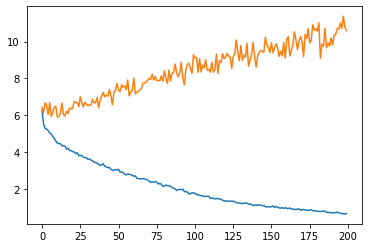

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

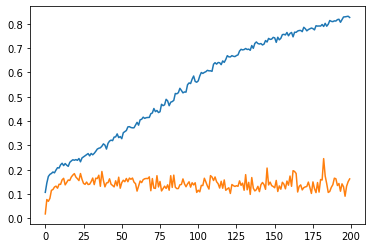

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([0.001,0.0001,4.5,6.5])

KeyError: ignored

In [ ]:
actor_model.save_weights('/content/policy_net_model_3.h5')

In [ ]:
#actor_model.load_weights()

In [ ]:
import numpy

In [ ]:
def caption_greedy(policy_net,image,tokenizer,word_index,max_length=25):
  caption='startseq'
  for i in range(max_length):
    input_seq=caption.split(' ')
    tokenization=tokenizer.texts_to_sequences(input_seq)
    padding=tf.keras.preprocessing.sequence.pad_sequences([tokenization],maxlen=max_length) 
    predicted_word_index=np.argmax(policy_net.predict([tf.expand_dims(image,axis=0),padding]))
    predicted_word=word_index[predicted_word_index]
    caption+=' '+predicted_word
    if predicted_word =='endseq':
      break
  return caption

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8360,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

Text(0.5, 1.0, 'startseq of people down street three written streets endseq')

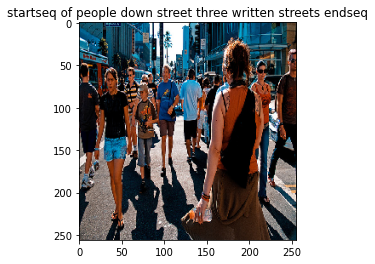

In [ ]:
test_img=list(test_cap_tok.keys())[5]
test_photo = load_preprocess_img(image_pth_rt + test_img)
cap=caption_greedy(actor_model,test_photo,tokenizer,word_index)
#plt.imshow(test_photo)
plt.title(cap)

In [ ]:
test_dataset = captions_generation_policy(test_cap_tok, vocab_size, image_pth_rt, max_length)